In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json

import os 
from time import time
from time import sleep

# import warnings
# warnings.filterwarnings('ignore')

In [2]:
from dotenv import load_dotenv
load_dotenv('.env')
API_KEY = os.environ.get("X-CMC_PRO_API_KEY")
API_KEY

'0ad53085-1cb2-4eb8-ad9e-3ffbd7e56509'

In [3]:
# extract data from coinmarktcap website
url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest' 
#Original Sandbox Environment: 'https://sandbox-api.coinmarketcap.com/v1/cryptocurrency/listings/latest'
parameters = {
  'start':'1',
  'limit':'15',
  'convert':'USD'
}
headers = {'Accepts': 'application/json', 'X-CMC_PRO_API_KEY': API_KEY}

session = Session()
session.headers.update(headers)

try:
  response = session.get(url, params=parameters)
  data = json.loads(response.text)
except (ConnectionError, Timeout, TooManyRedirects) as e:
  print(e)

In [4]:
#This allows you to see all the columns, not just like 15
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# One thing I noticed was the scientific notation. I like it, but I want to be able to see the numbers in this case
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [5]:
#This normalizes the data and makes it all pretty in a dataframe
df = pd.json_normalize(data['data'])
df['timestamp'] = pd.to_datetime('today')
df.head(2)

,id,name,symbol,slug,num_market_pairs,date_added,tags,max_supply,circulating_supply,total_supply,platform,cmc_rank,self_reported_circulating_supply,self_reported_market_cap,tvl_ratio,last_updated,quote.USD.price,quote.USD.volume_24h,quote.USD.volume_change_24h,quote.USD.percent_change_1h,quote.USD.percent_change_24h,quote.USD.percent_change_7d,quote.USD.percent_change_30d,quote.USD.percent_change_60d,quote.USD.percent_change_90d,quote.USD.market_cap,quote.USD.market_cap_dominance,quote.USD.fully_diluted_market_cap,quote.USD.tvl,quote.USD.last_updated,platform.id,platform.name,platform.symbol,platform.slug,platform.token_address,timestamp
0,1,Bitcoin,BTC,bitcoin,9648,2013-04-28T00:00:00.000Z,"[mineable, pow, sha-256, store-of-value, state...",21000000.00000,19109012.00000,19109012.00000,NaN,1,NaN,NaN,None,2022-08-01T03:55:00.000Z,23381.22976,22709379751.91493,-17.79070,-0.10702,-1.54708,7.02420,22.29237,-21.32546,-39.25917,446792200125.62164,41.05300,491005825033.65997,None,2022-08-01T03:55:00.000Z,NaN,NaN,NaN,NaN,NaN,2022-07-31 23:55:49.592184
1,1027,Ethereum,ETH,ethereum,5869,2015-08-07T00:00:00.000Z,"[mineable, pow, smart-contracts, ethereum-ecos...",NaN,121780057.87400,121780057.87400,NaN,2,NaN,NaN,None,2022-08-01T03:54:00.000Z,1690.58478,14108962677.74015,-3.70750,-0.16338,-0.21054,11.89207,62.73075,-6.89825,-40.63134,205879511814.52124,18.91700,205879511814.51999,None,2022-08-01T03:54:00.000Z,NaN,NaN,NaN,NaN,NaN,2022-07-31 23:55:49.592184


In [6]:
def api_runner():
    ''' put all together'''
    global df
    url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest' 
    #Original Sandbox Environment: 'https://sandbox-api.coinmarketcap.com/v1/cryptocurrency/listings/latest'
    parameters = {
      'start':'1',
      'limit':'15',
      'convert':'USD'
    }
    headers = {
      'Accepts': 'application/json',
      'X-CMC_PRO_API_KEY': '0ad53085-1cb2-4eb8-ad9e-3ffbd7e56509',
    }

    session = Session()
    session.headers.update(headers)

    try:
      response = session.get(url, params=parameters)
      data = json.loads(response.text)
      #print(data)
    except (ConnectionError, Timeout, TooManyRedirects) as e:
      print(e)
  
    # Use this if you just want to keep it in a dataframe
    df = pd.json_normalize(data['data'])
    df['Timestamp'] = pd.Timestamp("today")

    if not os.path.isfile(r'API.csv'):
        df.to_csv(r'API.csv', header='column_names', index=False)
    else:
        df.to_csv(r'API.csv', mode='a', header=False, index=False)

In [7]:
for i in range(2):
    api_runner()
    print('API Runner completed')
    sleep(10) #sleep for 1 minute

API Runner completed
API Runner completed


In [8]:
# Now let's look at the coin trends over time
vals_to_replace = {
            'quote.USD.percent_change_1h': '1h',
            'quote.USD.percent_change_24h': '24h',
            'quote.USD.percent_change_7d': '7d',
            'quote.USD.percent_change_30d': '30d',
            'quote.USD.percent_change_60d': '60d',
            'quote.USD.percent_change_90d': '90d'
        }

df3 = (df
    .groupby('name', sort=False)[['quote.USD.percent_change_1h','quote.USD.percent_change_24h','quote.USD.percent_change_7d','quote.USD.percent_change_30d','quote.USD.percent_change_60d','quote.USD.percent_change_90d']].mean()
    .stack()
    .to_frame(name='values')
    .reset_index()
    .rename(columns={'values': 'percent_change', 'level_1': 'time_frame'})
    .replace({'time_frame': vals_to_replace})
    )
df3.head()

,name,time_frame,percent_change
0,Bitcoin,1h,-0.10702
1,Bitcoin,24h,-1.54708
2,Bitcoin,7d,7.02420
3,Bitcoin,30d,22.29237
4,Bitcoin,60d,-21.32546


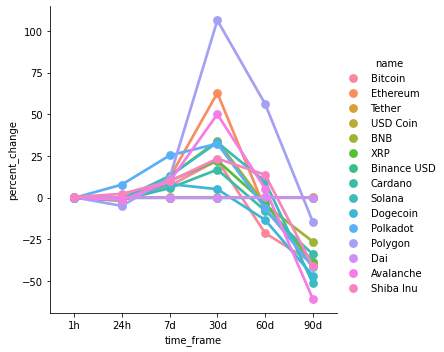

In [9]:
sns.catplot(x='time_frame', y='percent_change', hue='name', data=df3, kind='point');
plt.show()

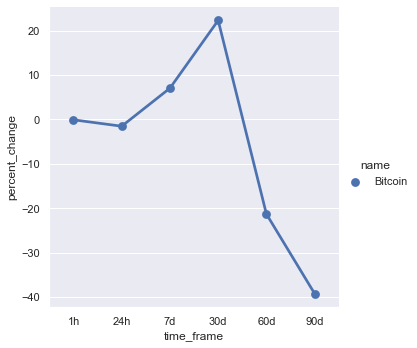

In [12]:
# we are going to create a dataframe with the columns we want
df4 = df3.query("name == 'Bitcoin'")
sns.set_theme(style="darkgrid")
sns.catplot(x='time_frame', y='percent_change', hue='name', data=df4, kind='point')

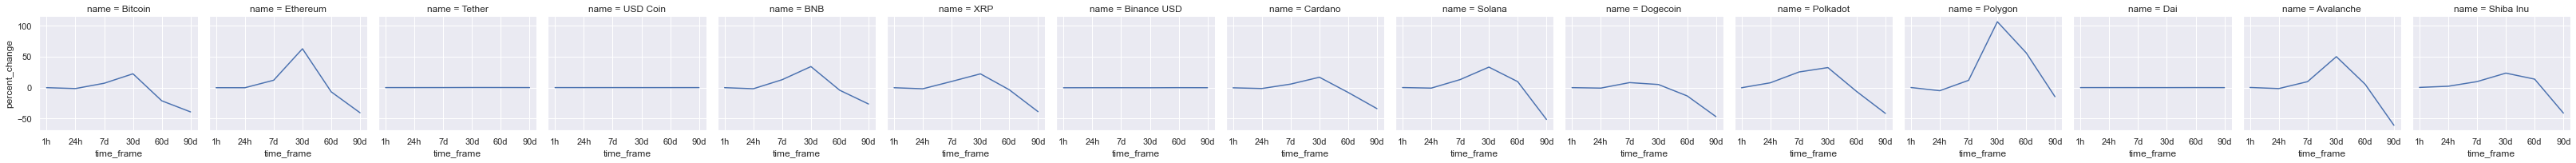

In [11]:
g = sns.FacetGrid(df3, col='name')
g.map(sns.lineplot, "time_frame", "percent_change")